In [1]:
import numpy as np
import matplotlib.pyplot as plt

import qiskit
from qiskit.providers.aer.noise.errors.standard_errors import thermal_relaxation_error
from qiskit.providers.aer.noise import NoiseModel

from qiskit.ignis.characterization.coherence import T1Fitter, T2StarFitter, T2Fitter
from qiskit.ignis.characterization.coherence import t1_circuits, t2_circuits, t2star_circuits

C:\Users\108997~1\AppData\Local\Temp/ipykernel_15904/279532431.py:8: DeprecationWarning: The qiskit.ignis package is deprecated and has been supersceded by the qiskit-experiments project. Refer to the migration guide: https://github.com/Qiskit/qiskit-ignis#migration-guide on how to migrate to the new project.
  from qiskit.ignis.characterization.coherence import T1Fitter, T2StarFitter, T2Fitter


In [2]:
num_of_gates = (np.linspace(10, 300, 50)).astype(int)
gate_time = 0.1

# Note that it is possible to measure several qubits in parallel
qubits = [0, 2]

t1_circs, t1_xdata = t1_circuits(num_of_gates, gate_time, qubits)
t2star_circs, t2star_xdata, osc_freq = t2star_circuits(num_of_gates, gate_time, qubits, nosc=5)
t2echo_circs, t2echo_xdata = t2_circuits(np.floor(num_of_gates/2).astype(int),
                                         gate_time, qubits)
t2cpmg_circs, t2cpmg_xdata = t2_circuits(np.floor(num_of_gates/6).astype(int),
                                         gate_time, qubits,
                                         n_echos=5, phase_alt_echo=True)

In [11]:
backend = qiskit.Aer.get_backend('qasm_simulator')
shots = 400

# Let the simulator simulate the following times for qubits 0 and 2:
t_q0 = 25.0
t_q2 = 15.0

# Define T1 and T2 noise:
t1_noise_model = NoiseModel()
t1_noise_model.add_quantum_error(
    thermal_relaxation_error(t_q0, 2*t_q0, gate_time),
    'id', [0])
t1_noise_model.add_quantum_error(
    thermal_relaxation_error(t_q2, 2*t_q2, gate_time),
    'id', [2])

t2_noise_model = NoiseModel()
t2_noise_model.add_quantum_error(
    thermal_relaxation_error(np.inf, t_q0, gate_time, 0.5),
    'id', [0])
t2_noise_model.add_quantum_error(
    thermal_relaxation_error(np.inf, t_q2, gate_time, 0.5),
    'id', [2])

# Run the simulator
t1_backend_result = qiskit.execute(t1_circs, backend, shots=shots,
                                   noise_model=t1_noise_model, optimization_level=0).result()
t2star_backend_result = qiskit.execute(t2star_circs, backend, shots=shots,
                                       noise_model=t2_noise_model, optimization_level=0).result()
t2echo_backend_result = qiskit.execute(t2echo_circs, backend, shots=shots,
                                       noise_model=t2_noise_model, optimization_level=0).result()

# It is possible to split the circuits into multiple jobs and then give the results to the fitter as a list:
t2cpmg_backend_result1 = qiskit.execute(t2cpmg_circs[0:5], backend,
                                        shots=shots, noise_model=t2_noise_model,
                                        optimization_level=0).result()
t2cpmg_backend_result2 = qiskit.execute(t2cpmg_circs[5:], backend,
                                        shots=shots, noise_model=t2_noise_model,
                                        optimization_level=0).result()

[30.663133467891704, 13.721708872093776]
[4.006274122391504, 0.6719255548845711]
{'0': [array([ 1.15109657, 30.66313347, -0.15133834]), array([ 0.97735467, 13.72170887,  0.02956163])]}
{'0': [array([0.09252023, 4.00627412, 0.09749216]), array([0.01485766, 0.67192555, 0.0181838 ])]}


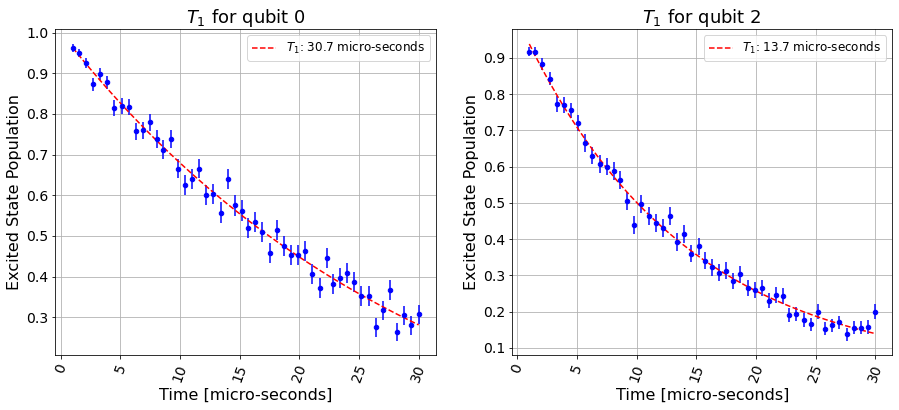

In [12]:
# Fitting T1

plt.figure(figsize=(15, 6))

t1_fit = T1Fitter(t1_backend_result, t1_xdata, qubits,
                  fit_p0=[1, t_q0, 0],
                  fit_bounds=([0, 0, -1], [2, 40, 1]))
print(t1_fit.time())
print(t1_fit.time_err())
print(t1_fit.params)
print(t1_fit.params_err)

for i in range(2):
    ax = plt.subplot(1, 2, i+1)
    t1_fit.plot(i, ax=ax)
plt.show()

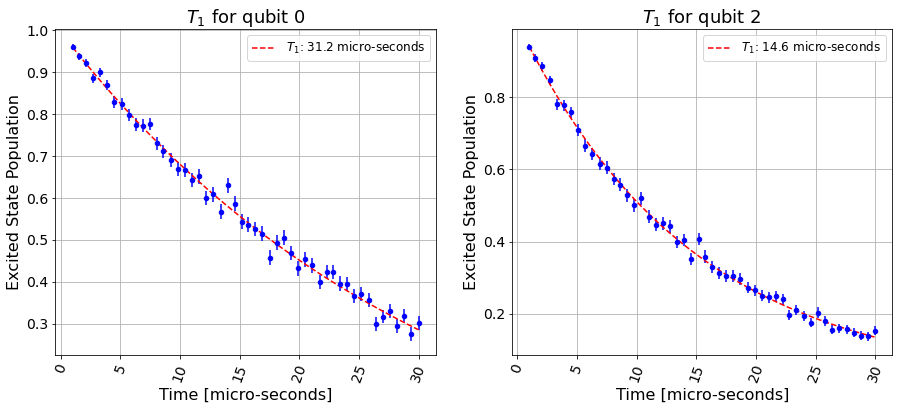

In [13]:
t1_backend_result_new = qiskit.execute(t1_circs, backend,
                                       shots=shots, noise_model=t1_noise_model,
                                       optimization_level=0).result()
t1_fit.add_data(t1_backend_result_new)

plt.figure(figsize=(15, 6))
for i in range(2):
    ax = plt.subplot(1, 2, i+1)
    t1_fit.plot(i, ax=ax)
plt.show()

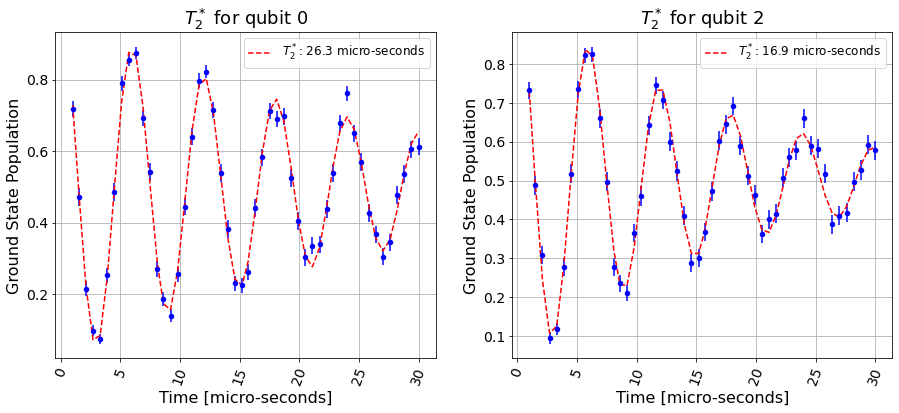

In [14]:
# Fitting T2*

t2star_fit = T2StarFitter(t2star_backend_result, t2star_xdata, qubits,
                          fit_p0=[0.5, t_q0, osc_freq, 0, 0.5],
                          fit_bounds=([-0.5, 0, 0, -np.pi, -0.5],
                                      [1.5, 40, 2*osc_freq, np.pi, 1.5]))

plt.figure(figsize=(15, 6))
for i in range(2):
    ax = plt.subplot(1, 2, i+1)
    t2star_fit.plot(i, ax=ax)
plt.show()

{'0': [array([ 0.46076763, 19.57240649,  0.55797271]), array([ 0.49340683, 14.25950413,  0.51629053])]}


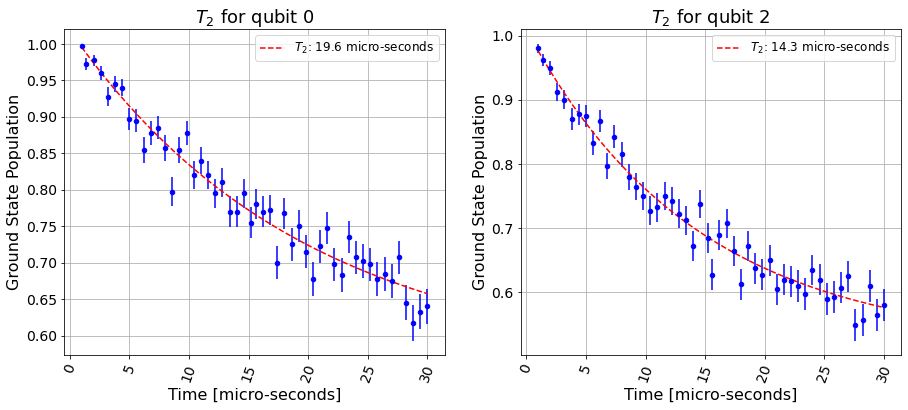

In [15]:
# Fitting T2 single echo

t2echo_fit = T2Fitter(t2echo_backend_result, t2echo_xdata, qubits,
                      fit_p0=[0.5, t_q0, 0.5],
                      fit_bounds=([-0.5, 0, -0.5],
                                  [1.5, 40, 1.5]))

print(t2echo_fit.params)

plt.figure(figsize=(15, 6))
for i in range(2):
    ax = plt.subplot(1, 2, i+1)
    t2echo_fit.plot(i, ax=ax)
plt.show()